In [ ]:
'''
Procedures
1. Generate the ICM spectral model 
(tbabs, CIE (normalization, varying temperature) )
2. Generate photons 
(XMM response file, exposure time)
3. take median energy from the photons
4. plot the median energy versus the temperature

'''

In [5]:
import numpy as np
import os


# 1. Generate the ICM spectral model 

In [ ]:
'''
1. Generate the ICM spectral model 
Model:
(tbabs, CIE)

Input parameters:
tbabs: nH=1e20 atom cm-2 (in xcop nH < 1e21) -> 0.01 in xspec
apec:  normalization, varying temperature
norm = 6e-4
z = 0.05 (xcop 0.04-0.1)
abundance = 0.3 solar abundance -> 0.3 to aspl
temperature = 0.1-3 keV, with bin 0.1 keV

how is norm decided
11.03-3.62 * 1e-3 suzaku norm at 60 arcmin(~r500)
2.73 -0.62 * 1e-3 suzaku norm at 80 arcmin(~r200)
assume the spectrum extraction region according to A222-223 sp arf
norm = 1.5e-3/400pi * area arcmin2
Tools: 
xspec

'''



In [84]:
'''
1. Load a xcm file in ideal_mdls
'''

T_arr = np.arange(0.1, 3.1, 0.1)
A_arr = np.array([147.69, 178.76, 299.47]) # arcmin2
INST_arr = ['mos1', 'mos2', 'pn']
norm_per_am = 1.5e-3/400/np.pi
reds = 0.05
abun = 1
nH = 0

os.chdir('/Users/eusracenorth/Documents/work/EXTG/ideal_mdls/bin')

f = open(f'gen_mdl.sh', 'w')
f.write('''
rm ../mdls/*.xcm
xspec << EOT
@../ideal-mdl_nH_1e20_z_005_suzakunorm_15e-4_T_1.xcm
''')

for T in T_arr:
    for i, A in enumerate(A_arr):
        INST = INST_arr[i]
        norm = norm_per_am * A
        f.write(f'''
new 1 {nH}
new 2 {T}
new 3 {abun}
new 5 {norm}
save mo ../mdls/ideal-mdl_nH_1e20_z_005_suzakunorm_15e-4_{INST}_A{int(A)}_T_{T:.1f}_abun{abun:.1f}_nH{nH:.3f}.xcm
        ''')
f.write('EOT')
f.close()


## in command line
# heainit
# sh gen_mdl.sh


# 2. Generate photons 
(XMM response file, exposure time)

Input parameters:
XMM response: MOS and PN 
()
texp = 1e6 s 
Tools:
fakeit

file: bin/mock_spectra.sh


In [85]:
#!/bin/bash

# Define your input filenames
exposure_time=1000000               # Replace with your desired exposure time in seconds
output_dir="../mock_spectras"  # Replace with your desired output directory

# Create the output directory if it doesn't exist
mkdir -p "$output_dir"

# Loop through XCM files in the current directory and generate mock spectra
for inst in mos1 mos2 pn; do
resp_file="${output_dir}/${inst}.rmf"  # Replace with your XMM response file
arf_file="${output_dir}/${inst}.arf"

for xspec_model_file in ../mdls/*${inst}*_abun*.xcm; do
# Extract the model name (excluding the .xcm extension) from the file
model_name="$(basename "$xspec_model_file" | sed 's/\.xcm$//')"
# Define the output spectrum filename based on the model name
output_spectrum="$output_dir/mock_spectrum_${model_name}.fak"

# Run XSpec in batch mode to generate the mock spectrum
xspec <<EOF
log >${output_spectrum}.log # no space after >!
data none               # Clear any existing data
@$xspec_model_file # Load the XCM model file
fakeit none
$resp_file  
$arf_file
n

$output_spectrum
$exposure_time, 1, 0
log none
exit
EOF

echo "Mock spectrum for $model_name generated and saved as $output_spectrum"
done
done

SyntaxError: invalid syntax (1407389480.py, line 8)

3. take median energy from the photons

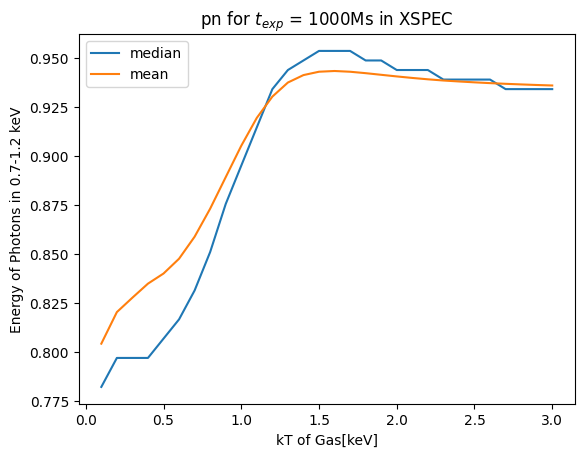

In [6]:
'''
1. load channel to energy in rmf file
2. load spectrum counts in 0.7-1.2 keV
3. cal median of the photons
'''
def take_median_idx(arr):
    return(np.argsort(arr)[len(arr)//2])

def take_mean_idx(arr):
    '''
    1. get the mean value in arr
    2. get the index where the value has the smallest absolute difference compare to the mean value
    '''
    mean_value = np.mean(arr)
    return np.argmin(abs(arr-mean_value))

os.chdir(f'/Users/eusracenorth/Documents/work/EXTG/ideal_mdls/mock_spectras')
from astropy.io import fits
from glob import glob
import matplotlib.pyplot as plt
import numpy as np


T_arr = np.arange(0.1, 3.1, 0.1)
t_exp = 1000000000


for INST in ['pn']: # 'mos1', 'mos2', 'pn'
    # load and filter the energy range
    rmf_file = fits.open(f'{INST}.rmf')
    Elo = rmf_file[2].data['E_MIN']
    # print(Elo)
    # filter ctr in 0.7-1.2 keV
    E_msk = (Elo>0.7) & (Elo<1.2)
    E_range = Elo[E_msk]

    # initialize  
    E_min_arr, E_max_arr, E_med_arr, E_mean_arr = np.zeros(T_arr.shape), np.zeros(T_arr.shape), np.zeros(T_arr.shape), np.zeros(T_arr.shape)

    for i, T in enumerate(T_arr):
        filename = glob(f'mock*tot_ideal-mdl*{INST}*T_{T:.1f}*abun0.3*nH0*.fak')[0]
        fak_file = fits.open(filename)
        ctr = fak_file[1].data['RATE']
        cts = np.array(ctr[E_msk] * t_exp).astype(int)
        data_arr = np.repeat(E_range, cts)

        E_mean_arr[i] = np.mean(data_arr)
        E_med_arr[i] = np.median(data_arr) # why median not sum or other summary statistics?

    # make the plot
    fig = plt.subplots()

    plt.plot(T_arr, E_med_arr, label = 'median')
    plt.plot(T_arr, E_mean_arr, label = 'mean')

    plt.title(f'{INST} for $t_{{exp}}$ = 1000Ms in XSPEC')
    # plt.ylabel('Counts [cts]')
    plt.ylabel('Energy of Photons in 0.7-1.2 keV')
    plt.xlabel('kT of Gas[keV]')
    plt.legend()




In [77]:
cts

array([219, 255, 295, ...,   0,   0,   0])

4. plot the median energy versus the temperature

In [56]:
import numpy as np

# Create a NumPy array
arr = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# Calculate the mean value of the array
mean_value = np.mean(arr)

# Get the indices where the array elements are equal to the mean
indices = np.where(arr == mean_value)

# Print the indices
print(indices)


(array([], dtype=int64),)


In [78]:
import numpy as np

# Define the values and the number of times they should appear
values = [4, 3]
counts = [3, 5]

# Create the new array using numpy.repeat
new_array = np.repeat(values, counts)

print(new_array)


[4 4 4 3 3 3 3 3]
